In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

RESPONSE_VARS = ['Limonene']

INPUT_VARS = ['ATOB_ECOLI','ERG8_YEAST','IDI_ECOLI',
                   'KIME_YEAST','MVD1_YEAST','Q40322_MENSP',
                   'Q8LKJ3_ABIGR','Q9FD86_STAAU','Q9FD87_STAAU']

DBTL_A = ['2X-Mh', 'B-Lm', '2X-Ll', 'A-Mm', 'B-Ll', 'A-Mh', '2X-Lm',
       'A-Hl', '2X-Hh', 'B-Ml', 'B-Mm', '2X-Lh', 'B-Mh', '2X-Hl', 'B-Hl',
       '2X-Ml', 'B-Hm', 'B-Lh', 'B-Hh', 'A-Ll', 'A-Hm', '2X-Mm', 'A-Hh',
       'A-Ml', 'A-Lm',  'A-Lh', '2X-Hm']

DBTL_B = ['BL-Mm', 'BL-Mh', 'BL-Ml']

## Read and transform data

In [2]:
def read_data(path: str) -> pd.DataFrame:
    ''' Read data from csv file '''
    df = pd.read_csv(path, index_col=0)
    df = df[['Line Name', 'Type', '24.0']] # Keep only columns EDD style
    df = df.rename(columns={'24.0': 'value'}) # Rename 24.0 to value
    return df

def transform_data(df: pd.DataFrame) -> pd.DataFrame:
    ''' Get data to the right format for analysis '''
    new_columns = df['Type'].unique()
    data = pd.DataFrame()
    data.index = df['Line Name'].unique()
    # add new columns to data
    for col in new_columns:
        data[col] = 0.0
    # fill in data
    for l in data.index:
        for c in new_columns:
            value = df[(df['Line Name'] == l) & (df['Type'] == c)]['value'].values
            data.loc[l, c] = value
    # drop OD column
    data.drop('Optical Density', axis=1, inplace=True)
    return data

In [3]:
df = read_data('data/limonene_data.csv')
df = transform_data(df)
print(df.shape)
df.head()

(30, 10)


,MVD1_YEAST,Q40322_MENSP,IDI_ECOLI,ATOB_ECOLI,Q8LKJ3_ABIGR,Q9FD87_STAAU,Q9FD86_STAAU,KIME_YEAST,ERG8_YEAST,Limonene
2X-Mh,2.1936,11.20370,3.18130,0.2384,0.29680,0.74880,0.78160,0.4010,0.94130,75.39261
B-Lm,0.9010,3.55060,1.06380,0.3550,0.28700,1.02540,0.89670,0.2006,0.50610,12.75786
BL-Mm,3.1930,11.31405,2.29065,1.2554,1.63235,0.41045,0.25975,1.0486,0.58985,119.81367
2X-Ll,1.9367,3.06770,1.59950,0.0457,0.14230,0.12100,0.09980,0.2709,0.46910,5.98466
A-Mm,1.2638,6.78340,1.74950,1.4896,3.70420,5.13260,3.97700,0.3517,1.18100,9.66957


In [4]:
# DBTL 1st cycle
data_A = df[df.index.isin(DBTL_A)]
# DBTL 2st cycle
data_B = df[df.index.isin(DBTL_B)]
# Reorder columns based on specific order
data_A = data_A[INPUT_VARS + RESPONSE_VARS]
data_B = data_B[INPUT_VARS + RESPONSE_VARS]

# Save data to csv files
data_A.to_csv('data/data_A.csv')
data_B.to_csv('data/data_B.csv')

## Basic statistical analysis on data

#### Describe dataset

In [5]:
df.describe()

,MVD1_YEAST,Q40322_MENSP,IDI_ECOLI,ATOB_ECOLI,Q8LKJ3_ABIGR,Q9FD87_STAAU,Q9FD86_STAAU,KIME_YEAST,ERG8_YEAST,Limonene
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,1.446219,5.042353,1.628000,0.570995,0.795225,1.450266,1.135938,0.324945,0.603852,36.509000
std,0.782276,3.170370,0.642693,0.549361,1.131095,1.592779,1.263955,0.270165,0.300270,37.367861
min,0.421500,1.233200,0.714300,0.021900,0.060500,0.042900,0.028000,0.098300,0.189900,1.655130
25%,0.876625,2.934350,1.060575,0.135575,0.163525,0.272475,0.183450,0.193325,0.381075,8.409443
50%,1.298455,3.940550,1.581600,0.297560,0.305750,0.657295,0.605800,0.284750,0.605575,19.614635
75%,1.782050,6.485125,2.051150,1.043300,0.573075,2.334900,1.630100,0.353125,0.772300,56.129280
max,4.104950,13.599190,3.181300,1.959830,4.526700,5.132600,3.977000,1.424960,1.390500,127.994940


__Distribution of every column of the 2 cycles__

Estimate the probability distrubtion that best describes every column

MVD1_YEAST : dweibull


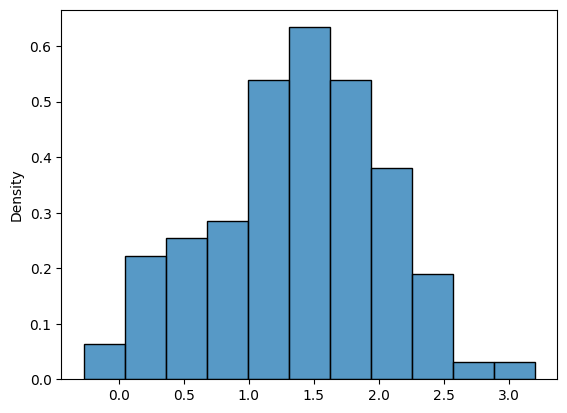

Q40322_MENSP : genextreme


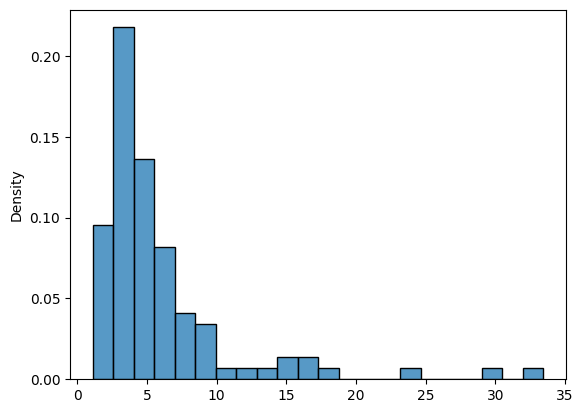

IDI_ECOLI : beta


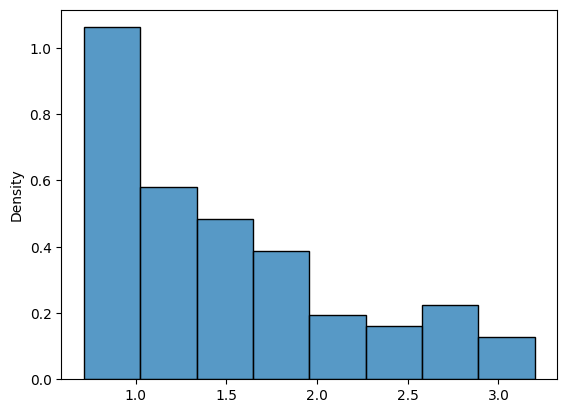

ATOB_ECOLI : lognorm


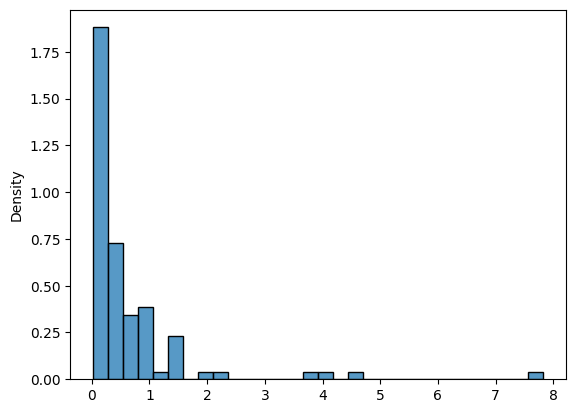

Q8LKJ3_ABIGR : t


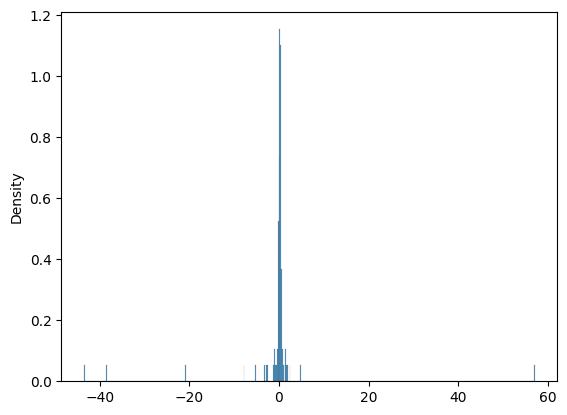

Q9FD87_STAAU : genextreme


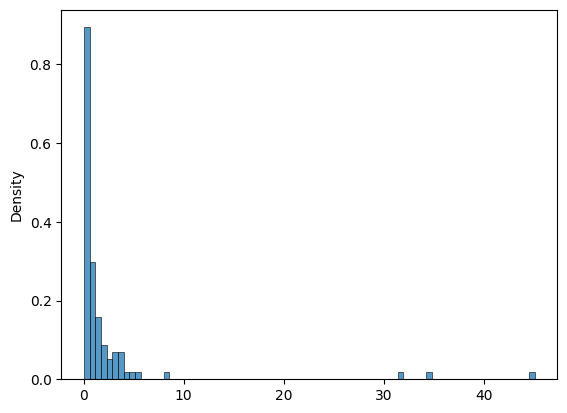

Q9FD86_STAAU : pareto


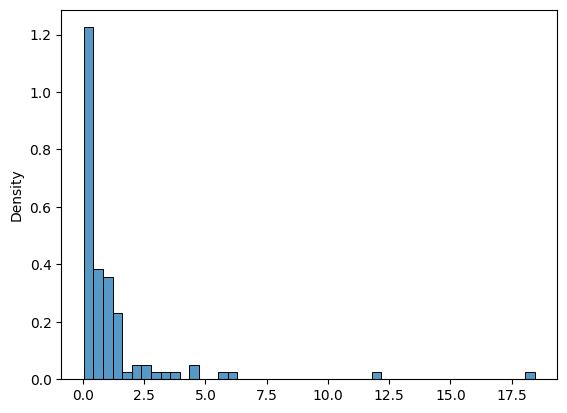

KIME_YEAST : t


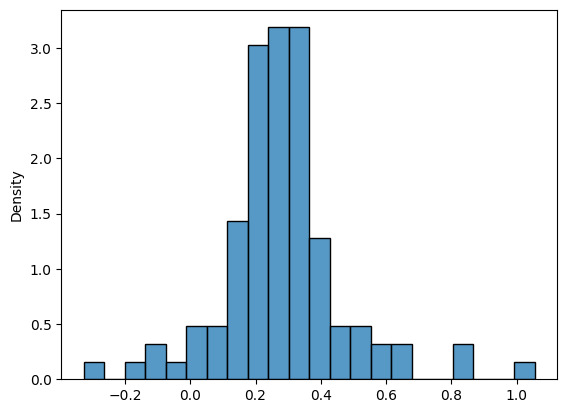

ERG8_YEAST : dweibull


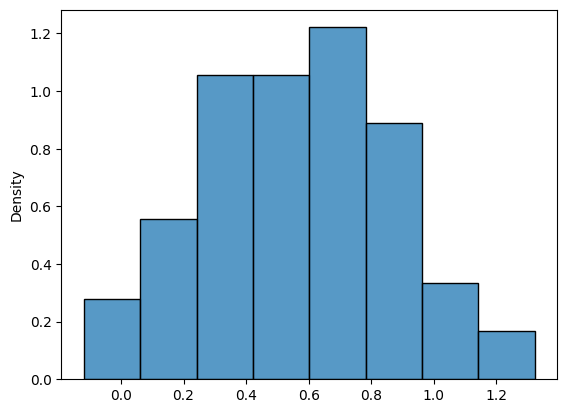

Limonene : lognorm


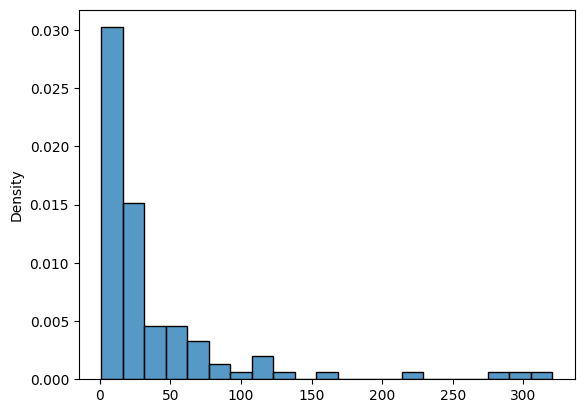

In [6]:
from distfit import distfit

for col in df.columns:
    dist = distfit()
    dist.fit_transform(df[col].values, verbose=0)
    print(f"{col} : {dist.model['name']}")
    X_synthetic = dist.generate(n=100)  # Produce synthetic data from the given distribution fitted by distfit
    sns.histplot(X_synthetic, stat='density', label='synthetic')
    plt.show()

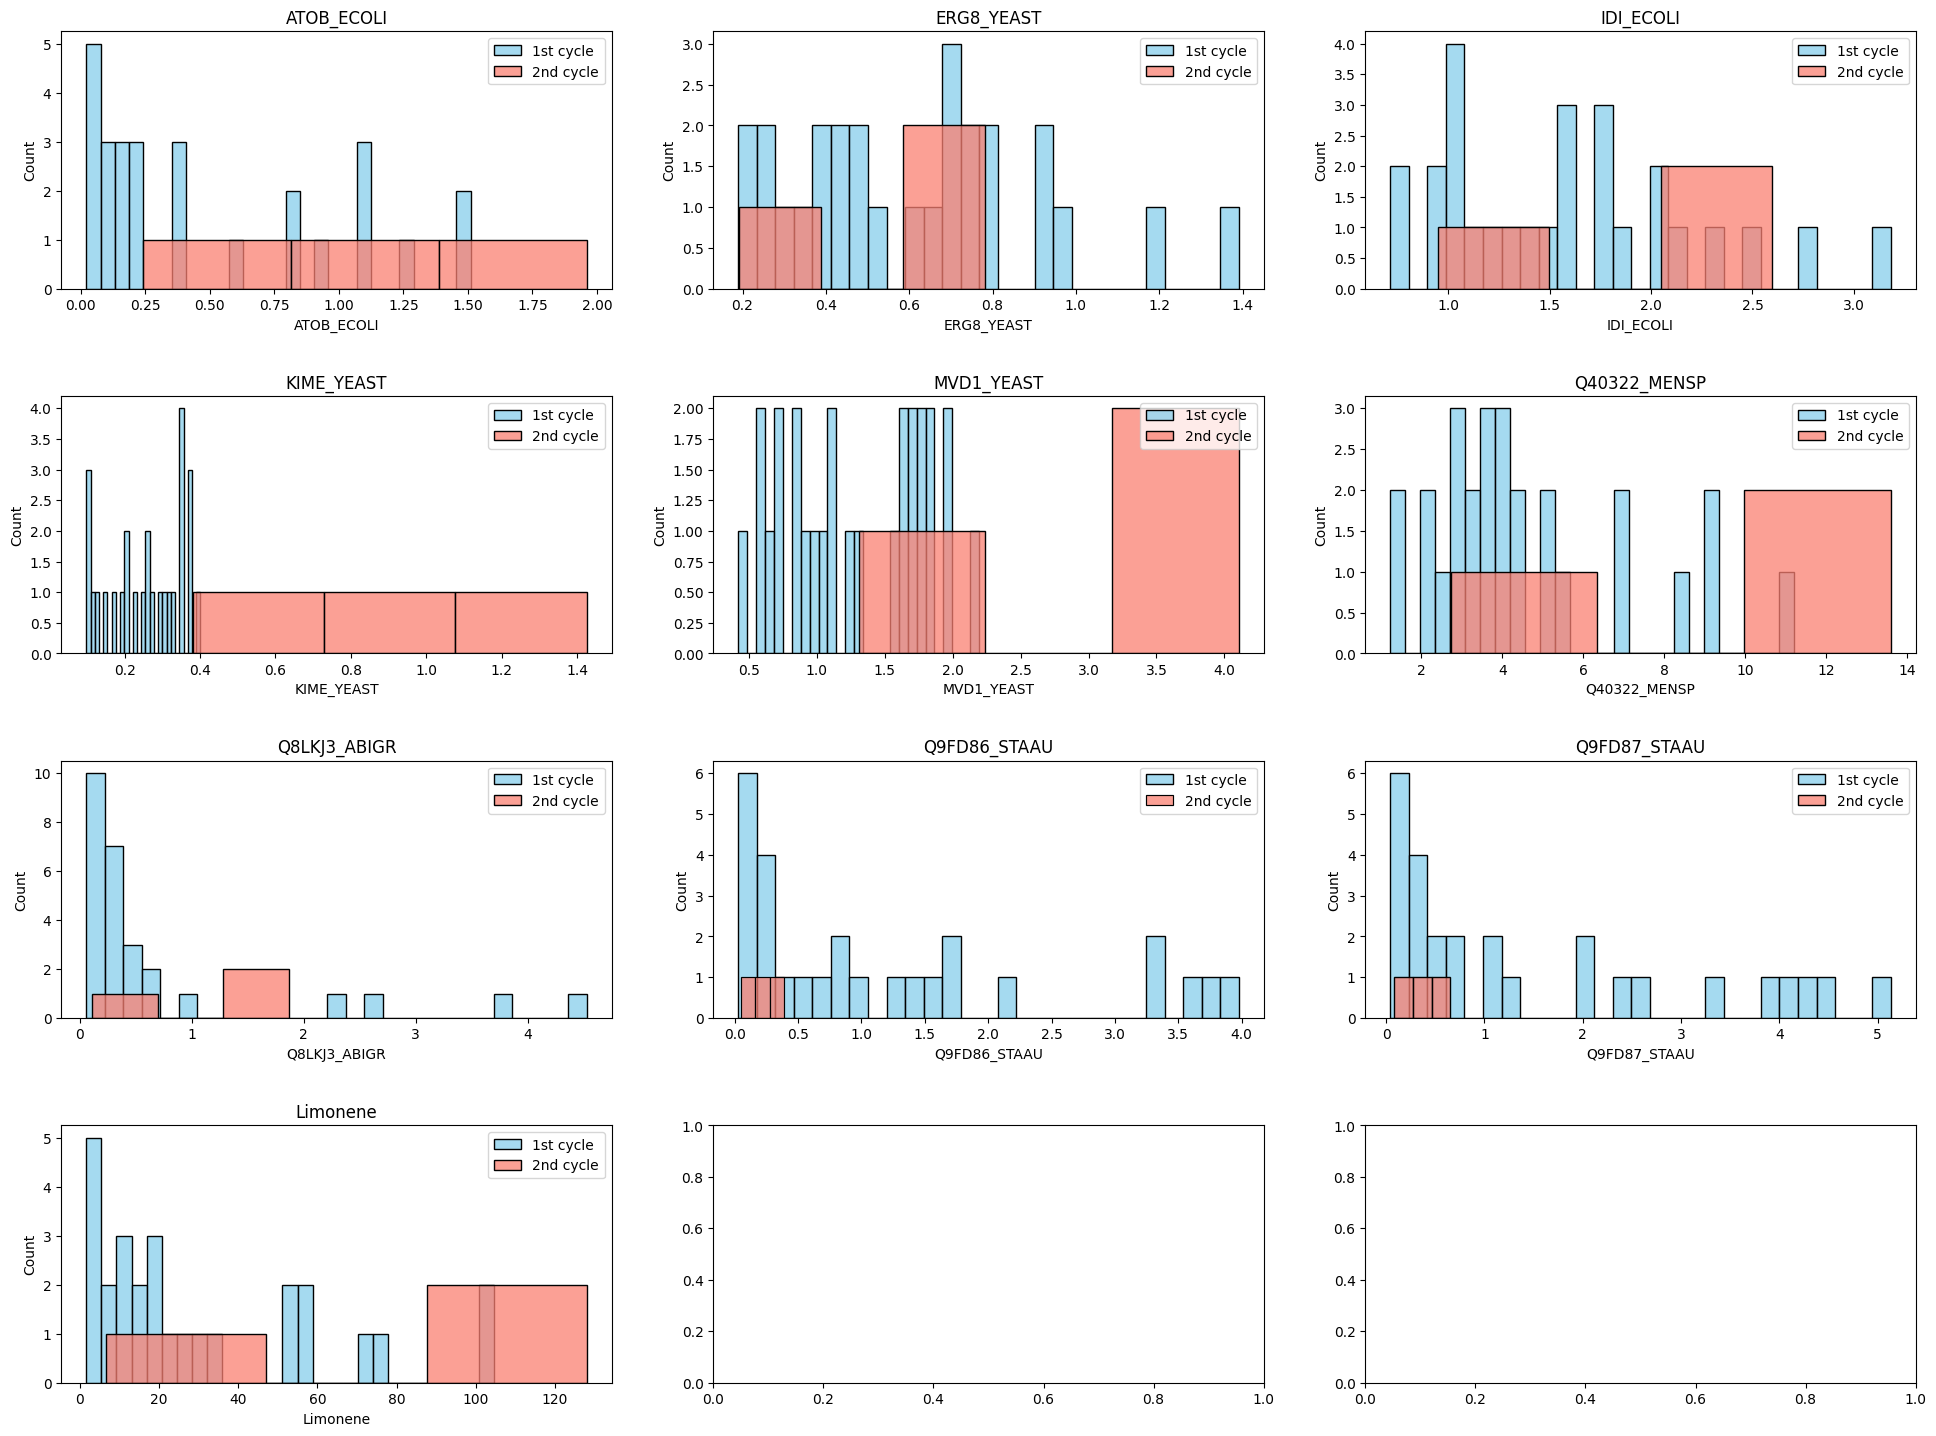

In [7]:
fig, axes = plt.subplots(4, 3, figsize=(20, 15))
for i, col in enumerate(data_A.columns):
    sns.histplot(data_A[col], ax=axes[i//3, i%3], bins=len(data_A), label='1st cycle', color='skyblue')
    sns.histplot(data_B[col], ax=axes[i//3, i%3], bins=len(data_B), label='2nd cycle', color='salmon')
    axes[i//3, i%3].set_title(col)
    axes[i//3, i%3].legend()
fig.tight_layout(pad=3.0)
plt.show()

__Limonene production__

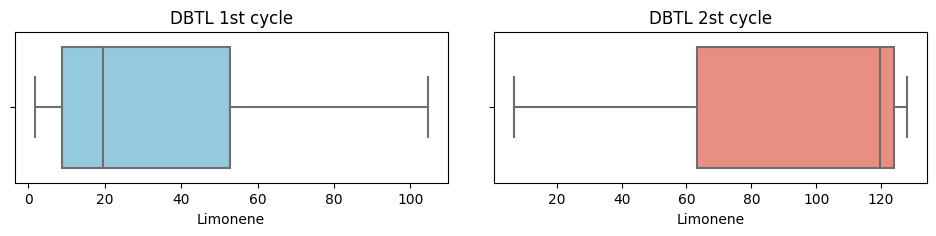

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
sns.boxplot(data=data_A, x='Limonene', ax=axes[0], color='skyblue')
sns.boxplot(data=data_B, x='Limonene', ax=axes[1], color='salmon')
axes[0].set_title('DBTL 1st cycle')
axes[1].set_title('DBTL 2st cycle')
fig.tight_layout(pad=3.0)
plt.show()

__PCA__

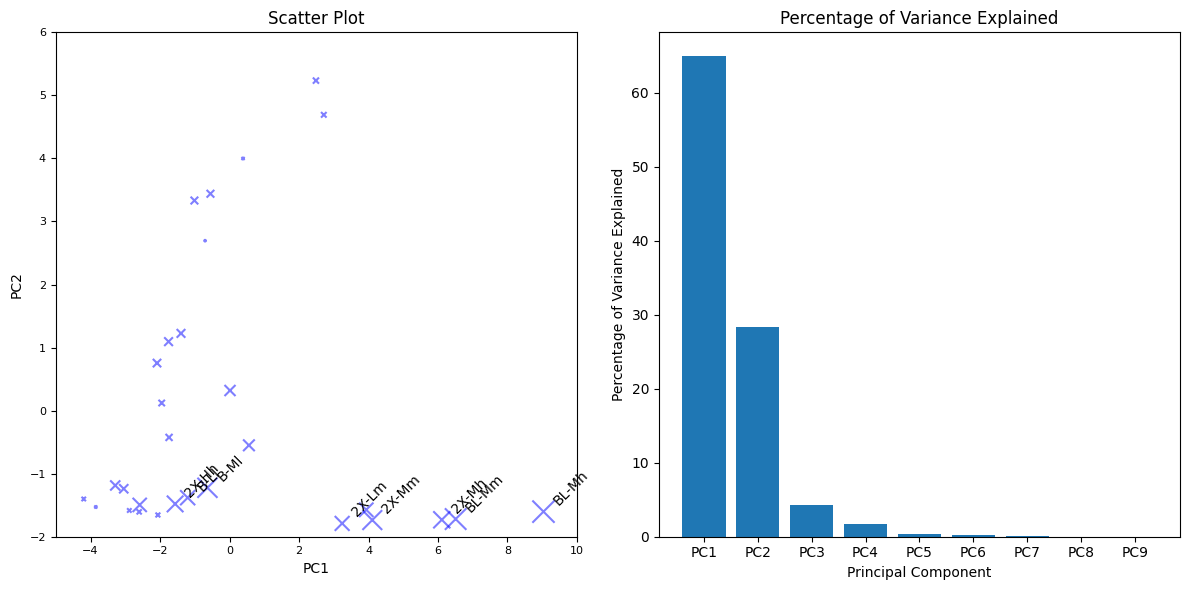

In [9]:
from sklearn.decomposition import PCA

def pca_analysis(df: pd.DataFrame, n_components=9):
    ''' Perform PCA analysis and plot results '''
    pca = PCA(n_components=n_components)
    pca_df = pd.DataFrame(pca.fit_transform(df.drop('Limonene', axis=1)))
    pca_df.index = df.index
    
    # Creating a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Scatter plot on the first subplot (axes[0])
    axes[0].scatter(pca_df[0], pca_df[1], s=df['Limonene']*2, color='blue', marker='x', alpha=0.5)
    axes[0].set_xlabel('PC1')
    axes[0].set_ylabel('PC2')
    axes[0].set_xlim([-5, 10])
    axes[0].set_ylim([-2, 6])
    axes[0].tick_params(labelsize=8)
    for i, txt in enumerate(pca_df.index):
        if df['Limonene'][i] > df['Limonene'].describe()["75%"]:
            axes[0].annotate(txt, (pca_df[0][i], pca_df[1][i]), xytext=(5, 5), 
                             textcoords='offset points', rotation=45)
    axes[0].set_title('Scatter Plot')

    # Bar plot on the second subplot (axes[1])
    pc_var = pca.explained_variance_ratio_
    pc_var = np.round(pc_var * 100, decimals=1)
    labels = ['PC' + str(x) for x in range(1, len(pc_var)+1)]
    axes[1].bar(x=range(1, len(pc_var)+1), height=pc_var, tick_label=labels)
    axes[1].set_ylabel('Percentage of Variance Explained')
    axes[1].set_xlabel('Principal Component')
    axes[1].set_title('Percentage of Variance Explained')

    plt.tight_layout()
    plt.show()

    return pca_df, pca
    
pca_df, pca = pca_analysis(df)

### ML Modeling

In [10]:
# Split data_A to X & y
X_train = data_A.drop('Limonene', axis=1)
y_train = data_A['Limonene'].copy()

X_test = data_B.drop('Limonene', axis=1)
y_test = data_B['Limonene'].copy()

In [11]:
import optuna 
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score

def objective(trial):
    C = trial.suggest_loguniform('C', 1e-1, 1e3)
    gamma = trial.suggest_loguniform('gamma', 1e-3, 1e3)
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf'])
    epsilon = trial.suggest_loguniform('epsilon', 1e-3, 1e3)
    
    svr = SVR(C=C, gamma=gamma, kernel=kernel, epsilon=epsilon)
    scores = cross_val_score(svr, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    return -scores.mean()

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
best_params = study.best_params
best_svr = SVR(**best_params)

score = cross_val_score(best_svr, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
best_svr.fit(X_train, y_train)
print(f'AVG(MAE) = {np.abs(score.mean())}')

[I 2023-12-19 12:04:22,895] A new study created in memory with name: no-name-b989e579-adfe-41bf-8df6-aaea73a515a0
[I 2023-12-19 12:04:22,921] Trial 0 finished with value: 13.834555805106096 and parameters: {'C': 1.0316490408530539, 'gamma': 0.09669401654669132, 'kernel': 'linear', 'epsilon': 0.0015147916082139641}. Best is trial 0 with value: 13.834555805106096.
[I 2023-12-19 12:04:22,944] Trial 1 finished with value: 17.43040986979019 and parameters: {'C': 0.23239217364833123, 'gamma': 2.3644261749793416, 'kernel': 'linear', 'epsilon': 0.10831021912510023}. Best is trial 0 with value: 13.834555805106096.
[I 2023-12-19 12:04:22,977] Trial 2 finished with value: 21.570736602650573 and parameters: {'C': 2.9524749793295277, 'gamma': 0.028515826603774306, 'kernel': 'rbf', 'epsilon': 0.6202677518067792}. Best is trial 0 with value: 13.834555805106096.
[I 2023-12-19 12:04:23,011] Trial 3 finished with value: 13.560286595506563 and parameters: {'C': 7.135455132546858, 'gamma': 172.52886206249

AVG(MAE) = 13.372111569251265


In [13]:
# Use optuna to tune a XGBoost model
import xgboost as xgb

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators',10, 100),
        'max_depth': trial.suggest_int('max_depth', 2, 25),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1e-1),
        'gamma': trial.suggest_loguniform('gamma', 1e-3, 1e1),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 1e1),
        'subsample': trial.suggest_loguniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 1e1),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 1e1),
        'random_state': 42,
        'n_jobs': -1
    }
    xgb_model = xgb.XGBRegressor(**params)
    scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    return -scores.mean()

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
best_params = study.best_params
best_xgb = xgb.XGBRegressor(**best_params)

score = cross_val_score(best_xgb, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
best_xgb.fit(X_train, y_train)
print(f'AVG(MAE) = {np.abs(score.mean())}')

[I 2023-12-19 12:04:56,524] A new study created in memory with name: no-name-eb969771-e55c-4008-8f4b-adadd817b6a8
[I 2023-12-19 12:04:57,475] Trial 0 finished with value: 16.410753387660726 and parameters: {'n_estimators': 70, 'max_depth': 17, 'learning_rate': 0.0838406080465496, 'gamma': 0.30090489430688644, 'min_child_weight': 0.001421923428806197, 'subsample': 0.672613188098986, 'colsample_bytree': 0.9026583335162385, 'reg_alpha': 8.968930164572361, 'reg_lambda': 0.00246909083175638}. Best is trial 0 with value: 16.410753387660726.
[I 2023-12-19 12:04:58,313] Trial 1 finished with value: 16.10568989921672 and parameters: {'n_estimators': 76, 'max_depth': 11, 'learning_rate': 0.09754710481858653, 'gamma': 0.03876194575178086, 'min_child_weight': 0.00463133038482167, 'subsample': 0.8146158975203187, 'colsample_bytree': 0.7392263668746166, 'reg_alpha': 3.263911358070325, 'reg_lambda': 0.2080364116105704}. Best is trial 1 with value: 16.10568989921672.
[I 2023-12-19 12:04:59,061] Trial 

AVG(MAE) = 12.859161739605714


In [14]:
# Use optuna to tune a ANN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error

def objective(trial):
    n_layers = trial.suggest_int('n_layers', 1, 5)
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    num_units = [trial.suggest_int(f'n_units_l{i}', 4, 128) for i in range(n_layers)]

    model = Sequential()
    for i in range(n_layers):
        if i == 0:
            model.add(Dense(num_units[i], activation='relu', input_shape=(X_train.shape[1],)))
        else:
            model.add(Dense(num_units[i], activation='relu'))
        model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='linear'))  # Linear activation for regression
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='mean_squared_error')  # Use mean squared error for regression

    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse

study = optuna.create_study(direction='minimize')  # Minimize mean squared error
study.optimize(objective, n_trials=50)

best_params = study.best_params
best_mse = study.best_value

print("Best MSE:", best_mse)
print("Best params:", best_params)

2023-12-19 12:06:47.206248: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-19 12:06:47.411335: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-12-19 12:06:47.411370: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-12-19 12:06:48.404750: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

1/1 [==============================] - 0s 86ms/step


[I 2023-12-19 12:06:51,006] Trial 0 finished with value: 10345.407282442922 and parameters: {'n_layers': 3, 'dropout_rate': 0.33718455264389763, 'learning_rate': 1.5966363429930602e-05, 'n_units_l0': 111, 'n_units_l1': 88, 'n_units_l2': 120}. Best is trial 0 with value: 10345.407282442922.


1/1 [==============================] - 0s 39ms/step


[I 2023-12-19 12:06:51,634] Trial 1 finished with value: 10078.862918129429 and parameters: {'n_layers': 1, 'dropout_rate': 0.45745798562693946, 'learning_rate': 0.0007311191426466396, 'n_units_l0': 91}. Best is trial 1 with value: 10078.862918129429.


1/1 [==============================] - 0s 44ms/step


[I 2023-12-19 12:06:52,593] Trial 2 finished with value: 9966.547009452332 and parameters: {'n_layers': 1, 'dropout_rate': 0.4507020260466345, 'learning_rate': 4.107251899256595e-05, 'n_units_l0': 106}. Best is trial 2 with value: 9966.547009452332.


1/1 [==============================] - 0s 43ms/step


[I 2023-12-19 12:06:53,263] Trial 3 finished with value: 9925.201604422014 and parameters: {'n_layers': 1, 'dropout_rate': 0.1626255132522103, 'learning_rate': 0.00010423731488162568, 'n_units_l0': 93}. Best is trial 3 with value: 9925.201604422014.


1/1 [==============================] - 0s 67ms/step


[I 2023-12-19 12:06:54,588] Trial 4 finished with value: 9162.851963519448 and parameters: {'n_layers': 5, 'dropout_rate': 0.3260014131488079, 'learning_rate': 0.001444968933461483, 'n_units_l0': 46, 'n_units_l1': 92, 'n_units_l2': 33, 'n_units_l3': 80, 'n_units_l4': 81}. Best is trial 4 with value: 9162.851963519448.


1/1 [==============================] - 0s 63ms/step


[I 2023-12-19 12:06:55,911] Trial 5 finished with value: 9736.390739439308 and parameters: {'n_layers': 5, 'dropout_rate': 0.3933470551199725, 'learning_rate': 0.00260345612656264, 'n_units_l0': 59, 'n_units_l1': 59, 'n_units_l2': 41, 'n_units_l3': 23, 'n_units_l4': 56}. Best is trial 4 with value: 9162.851963519448.


1/1 [==============================] - 0s 70ms/step


[I 2023-12-19 12:06:56,982] Trial 6 finished with value: 10334.859710304636 and parameters: {'n_layers': 4, 'dropout_rate': 0.3534566688520565, 'learning_rate': 1.3347174877073778e-05, 'n_units_l0': 70, 'n_units_l1': 100, 'n_units_l2': 96, 'n_units_l3': 122}. Best is trial 4 with value: 9162.851963519448.


1/1 [==============================] - 0s 47ms/step


[I 2023-12-19 12:06:57,765] Trial 7 finished with value: 9460.881335813276 and parameters: {'n_layers': 2, 'dropout_rate': 0.32222342193782044, 'learning_rate': 0.0008870245515953588, 'n_units_l0': 12, 'n_units_l1': 19}. Best is trial 4 with value: 9162.851963519448.


1/1 [==============================] - 0s 90ms/step


[I 2023-12-19 12:06:58,910] Trial 8 finished with value: 9266.991871056563 and parameters: {'n_layers': 4, 'dropout_rate': 0.3153631649871966, 'learning_rate': 0.002328976633923373, 'n_units_l0': 55, 'n_units_l1': 13, 'n_units_l2': 99, 'n_units_l3': 25}. Best is trial 4 with value: 9162.851963519448.


1/1 [==============================] - 0s 40ms/step


[I 2023-12-19 12:06:59,535] Trial 9 finished with value: 10602.213405248118 and parameters: {'n_layers': 1, 'dropout_rate': 0.16934137843021219, 'learning_rate': 0.0028569862160765947, 'n_units_l0': 14}. Best is trial 4 with value: 9162.851963519448.


1/1 [==============================] - 0s 84ms/step


[I 2023-12-19 12:07:00,855] Trial 10 finished with value: 1130.0726553197421 and parameters: {'n_layers': 5, 'dropout_rate': 0.01626654264652283, 'learning_rate': 0.007185952098763939, 'n_units_l0': 32, 'n_units_l1': 125, 'n_units_l2': 5, 'n_units_l3': 91, 'n_units_l4': 111}. Best is trial 10 with value: 1130.0726553197421.


1/1 [==============================] - 0s 66ms/step


[I 2023-12-19 12:07:02,317] Trial 11 finished with value: 1421.3818388926704 and parameters: {'n_layers': 5, 'dropout_rate': 0.04665615665353484, 'learning_rate': 0.0075415871719033, 'n_units_l0': 33, 'n_units_l1': 125, 'n_units_l2': 5, 'n_units_l3': 89, 'n_units_l4': 126}. Best is trial 10 with value: 1130.0726553197421.


1/1 [==============================] - 0s 62ms/step


[I 2023-12-19 12:07:03,551] Trial 12 finished with value: 1059.150924098598 and parameters: {'n_layers': 4, 'dropout_rate': 0.0007588857930978937, 'learning_rate': 0.009936872102523534, 'n_units_l0': 33, 'n_units_l1': 128, 'n_units_l2': 5, 'n_units_l3': 92}. Best is trial 12 with value: 1059.150924098598.


1/1 [==============================] - 0s 94ms/step


[I 2023-12-19 12:07:05,503] Trial 13 finished with value: 1977.5332661956172 and parameters: {'n_layers': 4, 'dropout_rate': 0.004839973095469408, 'learning_rate': 0.009478320629210842, 'n_units_l0': 30, 'n_units_l1': 127, 'n_units_l2': 11, 'n_units_l3': 108}. Best is trial 12 with value: 1059.150924098598.


1/1 [==============================] - 0s 54ms/step


[I 2023-12-19 12:07:06,650] Trial 14 finished with value: 676.6402188920991 and parameters: {'n_layers': 3, 'dropout_rate': 0.06510087239872268, 'learning_rate': 0.009084495491021366, 'n_units_l0': 32, 'n_units_l1': 111, 'n_units_l2': 51}. Best is trial 14 with value: 676.6402188920991.


1/1 [==============================] - 0s 78ms/step


[I 2023-12-19 12:07:07,977] Trial 15 finished with value: 10237.223038643977 and parameters: {'n_layers': 3, 'dropout_rate': 0.09025067035334015, 'learning_rate': 0.0001822789894246297, 'n_units_l0': 5, 'n_units_l1': 61, 'n_units_l2': 61}. Best is trial 14 with value: 676.6402188920991.


1/1 [==============================] - 0s 70ms/step


[I 2023-12-19 12:07:09,048] Trial 16 finished with value: 10035.774798202609 and parameters: {'n_layers': 2, 'dropout_rate': 0.09022066761798353, 'learning_rate': 0.0003467339624685899, 'n_units_l0': 80, 'n_units_l1': 107}. Best is trial 14 with value: 676.6402188920991.


1/1 [==============================] - 0s 58ms/step


[I 2023-12-19 12:07:10,098] Trial 17 finished with value: 1546.2476289085419 and parameters: {'n_layers': 3, 'dropout_rate': 0.21959645801054284, 'learning_rate': 0.004638939439747976, 'n_units_l0': 128, 'n_units_l1': 74, 'n_units_l2': 61}. Best is trial 14 with value: 676.6402188920991.


1/1 [==============================] - 0s 62ms/step


[I 2023-12-19 12:07:11,349] Trial 18 finished with value: 8131.4941946676945 and parameters: {'n_layers': 4, 'dropout_rate': 0.09684160224557584, 'learning_rate': 0.0036900736425910705, 'n_units_l0': 45, 'n_units_l1': 113, 'n_units_l2': 38, 'n_units_l3': 52}. Best is trial 14 with value: 676.6402188920991.


1/1 [==============================] - 0s 48ms/step


[I 2023-12-19 12:07:12,151] Trial 19 finished with value: 6918.946176735833 and parameters: {'n_layers': 2, 'dropout_rate': 0.0024403760598871, 'learning_rate': 0.008210878937044143, 'n_units_l0': 22, 'n_units_l1': 39}. Best is trial 14 with value: 676.6402188920991.


1/1 [==============================] - 0s 86ms/step


[I 2023-12-19 12:07:13,277] Trial 20 finished with value: 8756.747724901716 and parameters: {'n_layers': 4, 'dropout_rate': 0.062499458568021596, 'learning_rate': 0.0016822658401491853, 'n_units_l0': 52, 'n_units_l1': 83, 'n_units_l2': 81, 'n_units_l3': 55}. Best is trial 14 with value: 676.6402188920991.


1/1 [==============================] - 0s 95ms/step


[I 2023-12-19 12:07:14,672] Trial 21 finished with value: 1940.8160484253503 and parameters: {'n_layers': 5, 'dropout_rate': 0.008411030641165423, 'learning_rate': 0.005527651890552709, 'n_units_l0': 36, 'n_units_l1': 115, 'n_units_l2': 18, 'n_units_l3': 98, 'n_units_l4': 124}. Best is trial 14 with value: 676.6402188920991.


1/1 [==============================] - 0s 58ms/step


[I 2023-12-19 12:07:15,898] Trial 22 finished with value: 996.3387138578984 and parameters: {'n_layers': 4, 'dropout_rate': 0.05402785286177371, 'learning_rate': 0.009921555486426004, 'n_units_l0': 23, 'n_units_l1': 125, 'n_units_l2': 22, 'n_units_l3': 71}. Best is trial 14 with value: 676.6402188920991.


1/1 [==============================] - 0s 52ms/step


[I 2023-12-19 12:07:16,901] Trial 23 finished with value: 391.5842131735553 and parameters: {'n_layers': 3, 'dropout_rate': 0.1289884977830474, 'learning_rate': 0.009701785634118873, 'n_units_l0': 21, 'n_units_l1': 103, 'n_units_l2': 26}. Best is trial 23 with value: 391.5842131735553.


1/1 [==============================] - 0s 56ms/step


[I 2023-12-19 12:07:17,816] Trial 24 finished with value: 7438.5968489648485 and parameters: {'n_layers': 3, 'dropout_rate': 0.13647846010012932, 'learning_rate': 0.004798009845100536, 'n_units_l0': 20, 'n_units_l1': 101, 'n_units_l2': 27}. Best is trial 23 with value: 391.5842131735553.


1/1 [==============================] - 0s 46ms/step


[I 2023-12-19 12:07:18,568] Trial 25 finished with value: 8166.12177773541 and parameters: {'n_layers': 2, 'dropout_rate': 0.13412194340958836, 'learning_rate': 0.004237297643878762, 'n_units_l0': 22, 'n_units_l1': 110}. Best is trial 23 with value: 391.5842131735553.


1/1 [==============================] - 0s 52ms/step


[I 2023-12-19 12:07:19,571] Trial 26 finished with value: 9083.1621968546 and parameters: {'n_layers': 3, 'dropout_rate': 0.05382039020472699, 'learning_rate': 0.005097858616852969, 'n_units_l0': 7, 'n_units_l1': 74, 'n_units_l2': 50}. Best is trial 23 with value: 391.5842131735553.


1/1 [==============================] - 0s 61ms/step


[I 2023-12-19 12:07:21,254] Trial 27 finished with value: 7934.282668209865 and parameters: {'n_layers': 3, 'dropout_rate': 0.2161656158127922, 'learning_rate': 0.00281829774840898, 'n_units_l0': 42, 'n_units_l1': 97, 'n_units_l2': 23}. Best is trial 23 with value: 391.5842131735553.


1/1 [==============================] - 0s 54ms/step


[I 2023-12-19 12:07:22,287] Trial 28 finished with value: 2309.156064100808 and parameters: {'n_layers': 3, 'dropout_rate': 0.113422757822917, 'learning_rate': 0.009937219975285865, 'n_units_l0': 70, 'n_units_l1': 114, 'n_units_l2': 49}. Best is trial 23 with value: 391.5842131735553.


1/1 [==============================] - 0s 51ms/step


[I 2023-12-19 12:07:23,153] Trial 29 finished with value: 9751.795865128764 and parameters: {'n_layers': 2, 'dropout_rate': 0.06040279580848314, 'learning_rate': 0.001383165279470531, 'n_units_l0': 23, 'n_units_l1': 43}. Best is trial 23 with value: 391.5842131735553.


1/1 [==============================] - 0s 95ms/step


[I 2023-12-19 12:07:24,598] Trial 30 finished with value: 976.2332002108748 and parameters: {'n_layers': 4, 'dropout_rate': 0.16530579187041183, 'learning_rate': 0.005767696829396385, 'n_units_l0': 40, 'n_units_l1': 117, 'n_units_l2': 73, 'n_units_l3': 43}. Best is trial 23 with value: 391.5842131735553.


1/1 [==============================] - 0s 60ms/step


[I 2023-12-19 12:07:25,733] Trial 31 finished with value: 510.39896746850644 and parameters: {'n_layers': 4, 'dropout_rate': 0.1727888437234123, 'learning_rate': 0.006114905989284432, 'n_units_l0': 15, 'n_units_l1': 118, 'n_units_l2': 73, 'n_units_l3': 44}. Best is trial 23 with value: 391.5842131735553.


1/1 [==============================] - 0s 61ms/step


[I 2023-12-19 12:07:26,875] Trial 32 finished with value: 3004.4489539065958 and parameters: {'n_layers': 4, 'dropout_rate': 0.17949254254885427, 'learning_rate': 0.005790728260068311, 'n_units_l0': 13, 'n_units_l1': 106, 'n_units_l2': 77, 'n_units_l3': 40}. Best is trial 23 with value: 391.5842131735553.


1/1 [==============================] - 0s 53ms/step


[I 2023-12-19 12:07:27,883] Trial 33 finished with value: 3571.86323551627 and parameters: {'n_layers': 3, 'dropout_rate': 0.19691227027210884, 'learning_rate': 0.003560542835112209, 'n_units_l0': 41, 'n_units_l1': 117, 'n_units_l2': 77}. Best is trial 23 with value: 391.5842131735553.


1/1 [==============================] - 0s 46ms/step


[I 2023-12-19 12:07:28,826] Trial 34 finished with value: 464.2145690232813 and parameters: {'n_layers': 3, 'dropout_rate': 0.1425283204169263, 'learning_rate': 0.005973056924116364, 'n_units_l0': 63, 'n_units_l1': 89, 'n_units_l2': 88}. Best is trial 23 with value: 391.5842131735553.


1/1 [==============================] - 0s 54ms/step


[I 2023-12-19 12:07:29,788] Trial 35 finished with value: 7163.041002656541 and parameters: {'n_layers': 3, 'dropout_rate': 0.13930268334700416, 'learning_rate': 0.001989718636704342, 'n_units_l0': 89, 'n_units_l1': 87, 'n_units_l2': 91}. Best is trial 23 with value: 391.5842131735553.


1/1 [==============================] - 0s 60ms/step


[I 2023-12-19 12:07:30,752] Trial 36 finished with value: 7650.132659258669 and parameters: {'n_layers': 2, 'dropout_rate': 0.2557026578531101, 'learning_rate': 0.0033651516299992145, 'n_units_l0': 65, 'n_units_l1': 90}. Best is trial 23 with value: 391.5842131735553.


1/1 [==============================] - 0s 64ms/step


[I 2023-12-19 12:07:31,998] Trial 37 finished with value: 9646.98694813435 and parameters: {'n_layers': 3, 'dropout_rate': 0.11758595872250753, 'learning_rate': 0.001103304737047575, 'n_units_l0': 101, 'n_units_l1': 96, 'n_units_l2': 112}. Best is trial 23 with value: 391.5842131735553.


1/1 [==============================] - 0s 58ms/step


[I 2023-12-19 12:07:33,046] Trial 38 finished with value: 7823.138679976636 and parameters: {'n_layers': 3, 'dropout_rate': 0.1466386952956178, 'learning_rate': 0.0020834561841988975, 'n_units_l0': 81, 'n_units_l1': 79, 'n_units_l2': 53}. Best is trial 23 with value: 391.5842131735553.


1/1 [==============================] - 0s 52ms/step


[I 2023-12-19 12:07:34,027] Trial 39 finished with value: 9894.654725551083 and parameters: {'n_layers': 3, 'dropout_rate': 0.18496058616862462, 'learning_rate': 0.0005560033139909823, 'n_units_l0': 49, 'n_units_l1': 102, 'n_units_l2': 67}. Best is trial 23 with value: 391.5842131735553.


1/1 [==============================] - 0s 47ms/step


[I 2023-12-19 12:07:34,877] Trial 40 finished with value: 8681.632947231044 and parameters: {'n_layers': 2, 'dropout_rate': 0.15317089275734813, 'learning_rate': 0.0062489252153141925, 'n_units_l0': 15, 'n_units_l1': 93}. Best is trial 23 with value: 391.5842131735553.


1/1 [==============================] - 0s 68ms/step


[I 2023-12-19 12:07:37,150] Trial 41 finished with value: 9012.52664199213 and parameters: {'n_layers': 4, 'dropout_rate': 0.1582425074110219, 'learning_rate': 0.006479142402656507, 'n_units_l0': 59, 'n_units_l1': 119, 'n_units_l2': 87, 'n_units_l3': 7}. Best is trial 23 with value: 391.5842131735553.


1/1 [==============================] - 0s 104ms/step


[I 2023-12-19 12:07:38,537] Trial 42 finished with value: 4050.3965749416643 and parameters: {'n_layers': 4, 'dropout_rate': 0.11510753156930625, 'learning_rate': 0.003832550220570653, 'n_units_l0': 28, 'n_units_l1': 106, 'n_units_l2': 71, 'n_units_l3': 39}. Best is trial 23 with value: 391.5842131735553.


1/1 [==============================] - 0s 60ms/step


[I 2023-12-19 12:07:39,673] Trial 43 finished with value: 449.5751142895195 and parameters: {'n_layers': 3, 'dropout_rate': 0.17598513139976726, 'learning_rate': 0.006973488485377436, 'n_units_l0': 39, 'n_units_l1': 117, 'n_units_l2': 59}. Best is trial 23 with value: 391.5842131735553.


1/1 [==============================] - 0s 66ms/step


[I 2023-12-19 12:07:40,830] Trial 44 finished with value: 2879.469186001376 and parameters: {'n_layers': 3, 'dropout_rate': 0.20639880976364894, 'learning_rate': 0.006945713430189094, 'n_units_l0': 8, 'n_units_l1': 102, 'n_units_l2': 107}. Best is trial 23 with value: 391.5842131735553.


1/1 [==============================] - 0s 57ms/step


[I 2023-12-19 12:07:41,830] Trial 45 finished with value: 8407.50186325066 and parameters: {'n_layers': 3, 'dropout_rate': 0.23114907505692212, 'learning_rate': 0.0025028866225705495, 'n_units_l0': 17, 'n_units_l1': 120, 'n_units_l2': 58}. Best is trial 23 with value: 391.5842131735553.


1/1 [==============================] - 0s 102ms/step


[I 2023-12-19 12:07:43,018] Trial 46 finished with value: 5512.551059085974 and parameters: {'n_layers': 2, 'dropout_rate': 0.18129400191320386, 'learning_rate': 0.007097668898774635, 'n_units_l0': 29, 'n_units_l1': 109}. Best is trial 23 with value: 391.5842131735553.


1/1 [==============================] - 0s 70ms/step


[I 2023-12-19 12:07:44,573] Trial 47 finished with value: 5151.133886438867 and parameters: {'n_layers': 3, 'dropout_rate': 0.08678536198332937, 'learning_rate': 0.003042561271897996, 'n_units_l0': 61, 'n_units_l1': 122, 'n_units_l2': 42}. Best is trial 23 with value: 391.5842131735553.


1/1 [==============================] - 0s 52ms/step


[I 2023-12-19 12:07:45,490] Trial 48 finished with value: 4601.183292144938 and parameters: {'n_layers': 3, 'dropout_rate': 0.25078281180184675, 'learning_rate': 0.004490355948117179, 'n_units_l0': 37, 'n_units_l1': 87, 'n_units_l2': 84}. Best is trial 23 with value: 391.5842131735553.


1/1 [==============================] - 0s 49ms/step


[I 2023-12-19 12:07:46,119] Trial 49 finished with value: 8654.91830352609 and parameters: {'n_layers': 1, 'dropout_rate': 0.12779827132621485, 'learning_rate': 0.00804857490560831, 'n_units_l0': 49}. Best is trial 23 with value: 391.5842131735553.


Best MSE: 391.5842131735553
Best params: {'n_layers': 3, 'dropout_rate': 0.1289884977830474, 'learning_rate': 0.009701785634118873, 'n_units_l0': 21, 'n_units_l1': 103, 'n_units_l2': 26}


In [17]:
import sklearn

model = Sequential()
model.add(Dense(21, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.13))
model.add(Dense(103, activation='relu'))
model.add(Dropout(0.13))
model.add(Dense(26, activation='relu'))
model.add(Dropout(0.13))
model.add(Dense(1, activation='linear'))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0097),
              loss='mean_squared_error')

model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

# Cross validation with the best ANN model
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []

for train_index, test_index in kf.split(X_train):
    X_train_kf, X_test_kf = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_kf, y_test_kf = y_train.iloc[train_index], y_train.iloc[test_index]
    model.fit(X_train_kf, y_train_kf, epochs=100, batch_size=32, verbose=0)
    y_pred = model.predict(X_test_kf)
    mae = sklearn.metrics.mean_absolute_error(y_test_kf, y_pred)
    scores.append(mae)

print(f'AVG(MSE) = {np.abs(np.array(scores).mean())}')

1/1 [==============================] - 0s 20ms/step
AVG(MSE) = 10.26289469382426


## SHAP

In [32]:
import shap

explainer = shap.KernelExplainer(best_svr.predict, X_train)
shap_values = explainer.shap_values(X_train)

  0%|          | 0/27 [00:00<?, ?it/s]

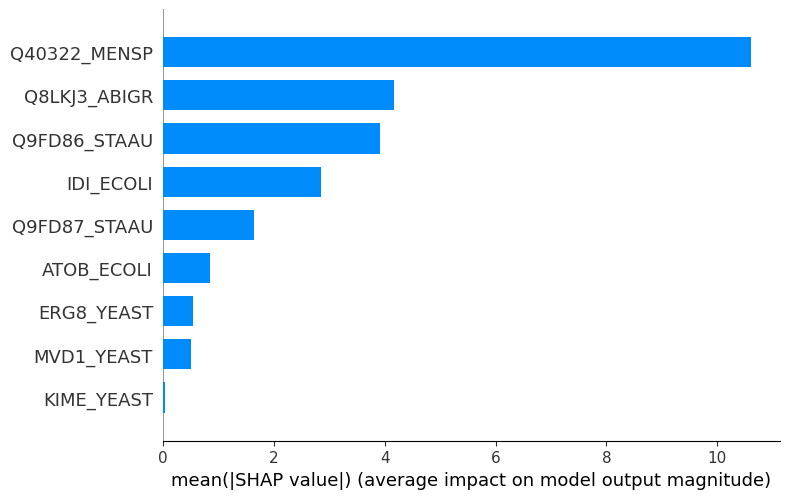

In [33]:
# Plot feature importances based on shap values
shap.summary_plot(shap_values, X_train, plot_type='bar')

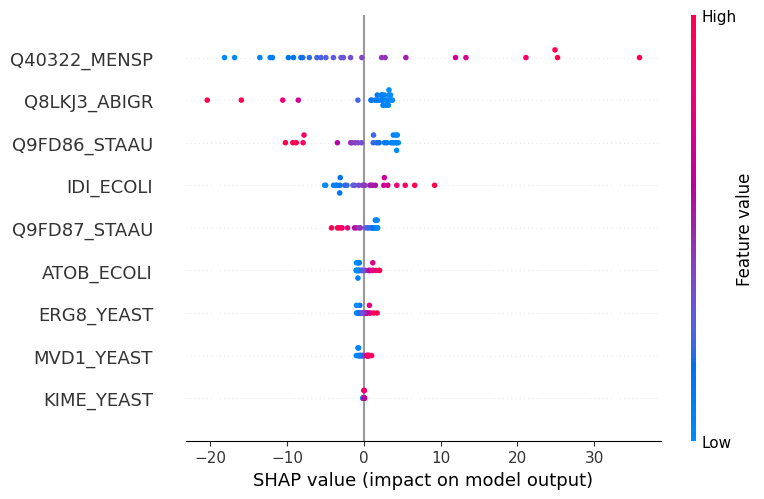

In [35]:
shap.summary_plot(shap_values, X_train, plot_type='dot')

In [40]:
from distfit import distfit

# Generate synthetic data for each feature
X_synthetic = pd.DataFrame()
for col in X_train.columns:
    dist = distfit()
    dist.fit_transform(X_train[col].values, verbose=0)
    X_synthetic[col] = dist.generate(n=500)  # Produce synthetic data from the given distribution fitted by distfit

# Drop rows with negative values
X_synthetic = X_synthetic[(X_synthetic > 0).all(axis=1)]
X_synthetic['Limonene'] = best_svr.predict(X_synthetic)
print(f'X_synthetic shape: {X_synthetic.shape}')    

X_synthetic shape: (419, 10)


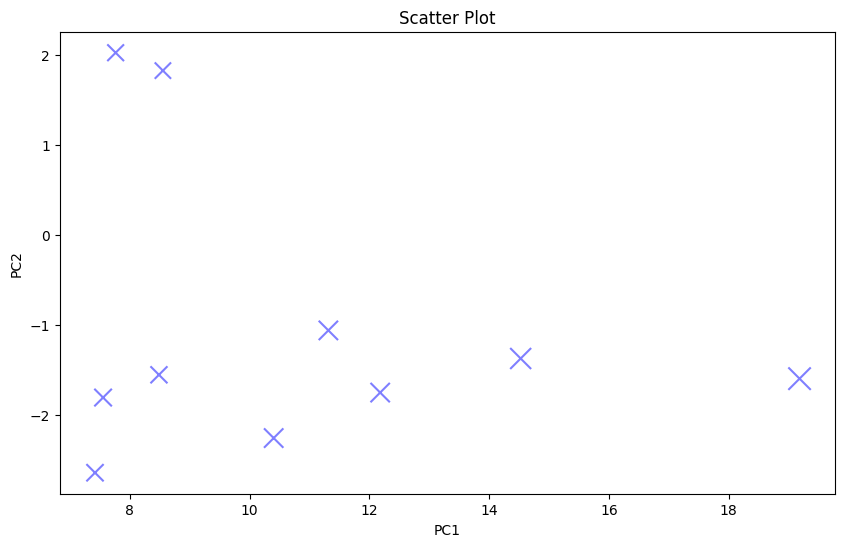

In [41]:
X_synthetic.sort_values(by='Limonene', ascending=False, inplace=True)
# Rearrage columns based on df columns
X_synthetic = X_synthetic[df.columns]
X_synthetic_pca = pca.transform(X_synthetic.drop('Limonene', axis=1))
X_synthetic_pca = pd.DataFrame(X_synthetic_pca)

# Keep only first N rows
N = 10
X_synthetic_pca = X_synthetic_pca.head(N)
X_synthetic = X_synthetic.head(N)

# Plot synthetic data
plt.figure(figsize=(10, 6))
plt.scatter(X_synthetic_pca[0], X_synthetic_pca[1], s=X_synthetic['Limonene']*2, color='blue', marker='x', alpha=0.5)
# plt.xlim([-5, 10])
# plt.ylim([-2, 6])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Scatter Plot')
plt.show()